In [1]:
import sys
sys.path = ['/eos/user/d/dvalsecc/.local/lib/python3.9/site-packages'] + sys.path

In [4]:
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
from coffea.util import load
import hist
import os
from pprint import pprint 
hep.style.use(hep.style.ROOT)
import vector
vector.register_awkward()

import hist
import numba

In [2]:
import deltaR_matching

In [37]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/TTbar_MC_Run3_noise235fb_thres235fb/"
os.makedirs(output_folder,exist_ok=True)
input_folder_must = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTTo2L2Nu_powheg_pythia8_13p6TeV_PremixRun3PU40/RECO_Mustache_thres235fb/230307_154857"
input_folder_deep = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTTo2L2Nu_powheg_pythia8_13p6TeV_PremixRun3PU40/RECO_DeepSC_algoA_thres235fb/230307_155019"

In [38]:
dfM = uproot.lazy(f"{input_folder_must}/0000/output_1.root:recosimdumper/caloTree", num_workers=3)
dfD = uproot.lazy(f"{input_folder_deep}/0000/output_1.root:recosimdumper/caloTree", num_workers=3)

In [5]:
dfD = uproot.lazy(f"output_badder.root:recosimdumper/caloTree", num_workers=3)

In [11]:
dfD.fields

['eventId',
 'lumiId',
 'runId',
 'rho',
 'nVtx',
 'truePU',
 'obsPU',
 'genParticle_size',
 'genParticle_genMotherIndex',
 'genParticle_genDaughtersIndex',
 'genParticle_pdgId',
 'genParticle_status',
 'genParticle_energy',
 'genParticle_pt',
 'genParticle_eta',
 'genParticle_phi',
 'genParticle_pfCluster_dR_genScore_MatchedIndex',
 'genParticle_superCluster_dR_genScore_MatchedIndex',
 'pfCluster_rawEnergy',
 'pfCluster_energy',
 'pfCluster_rawPt',
 'pfCluster_pt',
 'pfCluster_eta',
 'pfCluster_phi',
 'pfCluster_ieta',
 'pfCluster_iphi',
 'pfCluster_iz',
 'pfCluster_nXtals',
 'pfCluster_etaWidth',
 'pfCluster_phiWidth',
 'pfCluster_e5x5',
 'pfCluster_e2x2Ratio',
 'pfCluster_e3x3Ratio',
 'pfCluster_eMaxRatio',
 'pfCluster_e2ndRatio',
 'pfCluster_eTopRatio',
 'pfCluster_eRightRatio',
 'pfCluster_eBottomRatio',
 'pfCluster_eLeftRatio',
 'pfCluster_e2x5MaxRatio',
 'pfCluster_e2x5TopRatio',
 'pfCluster_e2x5RightRatio',
 'pfCluster_e2x5BottomRatio',
 'pfCluster_e2x5LeftRatio',
 'pfCluster_s

In [4]:
@numba.njit
def genparticle_mother_pdgId(genparticle_mother_index, genparticle_pdgid,genparticle_status, builder):
    for mother_index,pdgId, status  in zip(genparticle_mother_index, genparticle_pdgid,genparticle_status):
        builder.begin_list()
        
        for i in range(len(pdgId)):
            if status[i]!=1 or abs(pdgId[i])!=11: continue
            builder.begin_record()
            builder.field('index').append(i)
            genpart_i = i
            while True:
                if mother_index[genpart_i] == -1:
                    builder.field("pdgId").append(pdgId[genpart_i])
                    break
                else:
                    genpart_i = mother_index[genpart_i]
            builder.end_record()
        builder.end_list()
    return builder

In [84]:
len(dfD.genParticle_pdgId[0])

10903

In [67]:
dfD.genParticle_statusFlag[(dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)][0].tolist()

[12673, 12352, 12352, 12352, 12352]

(array([2., 0., 0., 3., 0., 1., 2., 0., 1., 1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

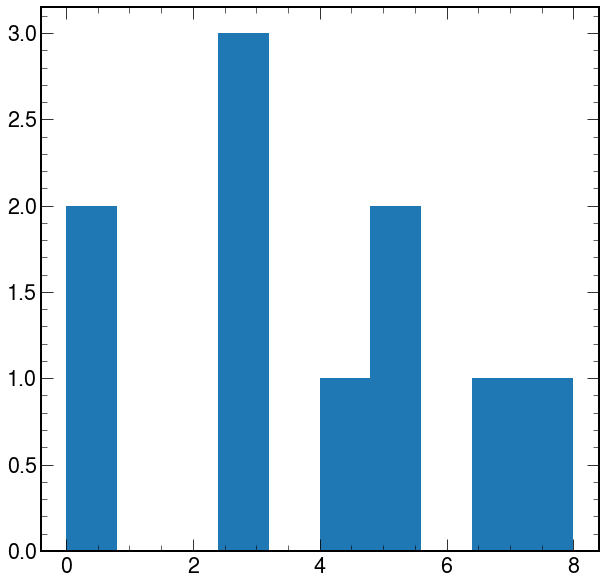

In [68]:
n_gen_electron = ak.sum((dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11), axis=1)

plt.hist(n_gen_electron)

(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

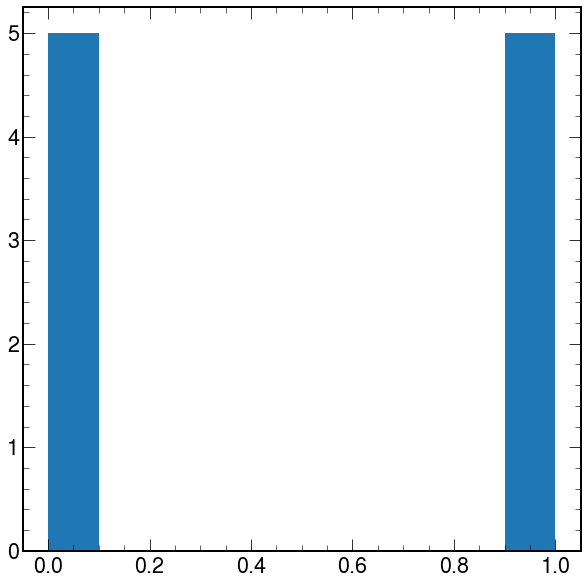

In [69]:
n_gen_electron = ak.sum((dfD.genParticle_status==1)&(dfD.genParticle_statusFlag&1==1)&(abs(dfD.genParticle_pdgId)==11), axis=1)

plt.hist(n_gen_electron)

In [29]:
ak.sum((dfD.genParticle_status==1), axis=1)

<Array [34, 40, 23, 36, 20, ... 19, 52, 31, 42] type='10 * int64'>

In [71]:
local_index = ak.local_index(dfD.genParticle_status)
electrons = local_index[(dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)]

In [100]:
mother_pdgid = genparticle_mother_pdgId(dfD.genParticle_genMotherIndex, 
                         dfD.genParticle_pdgId,
                         dfD.genParticle_status,
                         ak.ArrayBuilder()).snapshot()


In [108]:
mother_pdgid[2]

<Array [{index: 1410, ... pdgId: 111}] type='5 * {"index": int64, "pdgId": int64}'>

In [73]:
ev = 1
for i in electrons[ev]:
    while True:
        print(f"genpar: {i}, status {dfD.genParticle_status[ev][i]}, pdgid {dfD.genParticle_pdgId[ev][i]} \
        eta:{dfD.genParticle_eta[ev][i]:.3f} pt:{dfD.genParticle_pt[ev][i]:.3f} \
        isDecayedLeptonHadron: {dfD.genParticle_statusFlag[ev][i]&2==1} \
        isHardProcess: {dfD.genParticle_statusFlag[ev][i]&7==1}")
        if dfD.genParticle_genMotherIndex[ev][i] == -1:
            print("Reached the end")
            break
        else:
            i = dfD.genParticle_genMotherIndex[ev][i]

genpar: 59, status 1, pdgid 11         eta:-0.385 pt:15.293         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 57, status 23, pdgid 11         eta:-0.413 pt:15.888         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 47, status 52, pdgid -24         eta:-1.686 pt:64.993         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 44, status 22, pdgid -24         eta:-1.639 pt:70.603         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 34, status 62, pdgid -6         eta:-2.345 pt:61.751         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 18, status 44, pdgid -6         eta:-2.347 pt:61.656         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 15, status 44, pdgid -6         eta:-2.344 pt:61.926         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 13, status 44, pdgid -6         eta:-2.348 pt:61.565         isDecayedLeptonHadron: False         isHardProce

# Matching genParticles to reco objects

In [72]:
gen_mask_ele = (dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)#&(dfD.genParticle_statusFlag&1==1)
genParticles = ak.with_name(ak.zip({
    "pt": dfD.genParticle_pt[gen_mask_ele],
    "eta": dfD.genParticle_eta[gen_mask_ele],
    "phi": dfD.genParticle_phi[gen_mask_ele],
    "M": ak.zeros_like(dfD.genParticle_pt[gen_mask_ele])
}), name="Momentum4D")

In [73]:
sc = ak.with_name(ak.zip({
    "pt": dfD.superCluster_energy / np.cosh(dfD.superCluster_eta),
    "eta": dfD.pfCluster_eta[dfD.superCluster_seedIndex],  # seed Eta
    "phi": dfD.pfCluster_phi[dfD.superCluster_seedIndex],
    "E": dfD.superCluster_energy,
}), name="Momentum4D")

In [156]:
electrons = ak.with_name(ak.zip({
    "pt": dfD.patElectron_pt,
    "eta": dfD.patElectron_eta,
    "phi": dfD.patElectron_phi,
    "M": ak.zeros_like(dfD.patElectron_pt),
}), name="Momentum4D")

In [75]:
ak.num(sc)

<Array [3, 3, 7, 6, 5, 4, ... 6, 9, 7, 5, 4, 6] type='200 * int64'>

In [76]:
ak.num(genParticles)

<Array [9, 10, 5, 0, 13, 5, ... 20, 9, 9, 2, 5] type='200 * int64'>

### Matching

In [160]:
matched_sc, matched_genpart_sc, deltaR_cc, idx_sc, idx_genpart_sc, deltaR_masked_sc = deltaR_matching.get_unique_match(sc, genParticles, deltaRmax=0.2)
matched_ele, matched_genpart_ele, deltaR_ele, idx_ele, idx_genpart_ele, deltaR_masked_ele = deltaR_matching.get_unique_match(electrons, genParticles, deltaRmax=0.2)
is_genmatched_sc = ~ak.is_none(matched_genpart_sc, axis=1)
is_genmatched_ele = ~ak.is_none(matched_genpart_ele, axis=1)

In [78]:
matched_sc[2].tolist()

[{'pt': 79.38996124267578,
  'eta': -1.5297189950942993,
  'phi': 1.6658562421798706,
  'E': 191.86474609375},
 None,
 None,
 None,
 None]

In [79]:
matched_genpart[2].tolist()

[{'pt': 82.48982238769531,
  'eta': -1.5227717161178589,
  'phi': 1.676742672920227,
  'M': 0.0},
 None,
 None,
 None,
 None]

(array([2., 1., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.00507218, 0.01081818, 0.01656417, 0.02231017, 0.02805616,
        0.03380216, 0.03954815, 0.04529414, 0.05104014, 0.05678613,
        0.06253213]),
 <BarContainer object of 10 artists>)

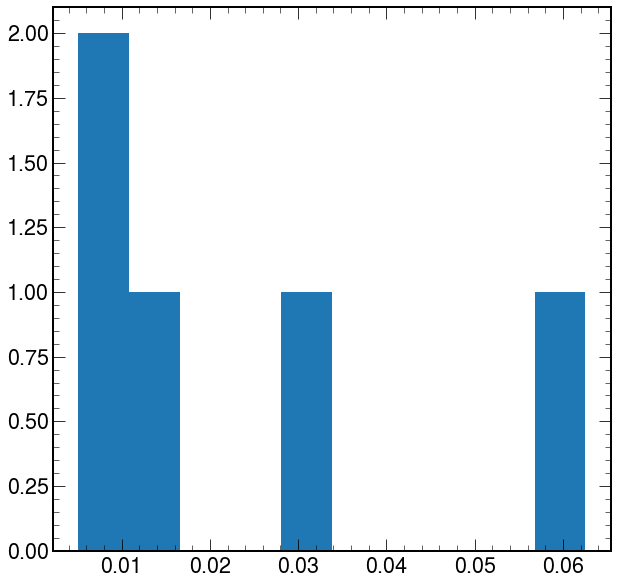

In [23]:
plt.hist(ak.flatten(deltaR_Sc))

In [24]:
idx_genpart_sc

<Array [[0], [0], [0], ... [0], [], [], [0]] type='10 * var * int64'>

## Prepare output

In [59]:
dfD.fields

['eventId',
 'lumiId',
 'runId',
 'rho',
 'nVtx',
 'truePU',
 'obsPU',
 'genParticle_size',
 'genParticle_genMotherIndex',
 'genParticle_genDaughtersIndex',
 'genParticle_pdgId',
 'genParticle_status',
 'genParticle_energy',
 'genParticle_pt',
 'genParticle_eta',
 'genParticle_phi',
 'genParticle_pfCluster_dR_genScore_MatchedIndex',
 'genParticle_superCluster_dR_genScore_MatchedIndex',
 'pfCluster_rawEnergy',
 'pfCluster_energy',
 'pfCluster_rawPt',
 'pfCluster_pt',
 'pfCluster_eta',
 'pfCluster_phi',
 'pfCluster_ieta',
 'pfCluster_iphi',
 'pfCluster_iz',
 'pfCluster_nXtals',
 'pfCluster_etaWidth',
 'pfCluster_phiWidth',
 'pfCluster_e5x5',
 'pfCluster_e2x2Ratio',
 'pfCluster_e3x3Ratio',
 'pfCluster_eMaxRatio',
 'pfCluster_e2ndRatio',
 'pfCluster_eTopRatio',
 'pfCluster_eRightRatio',
 'pfCluster_eBottomRatio',
 'pfCluster_eLeftRatio',
 'pfCluster_e2x5MaxRatio',
 'pfCluster_e2x5TopRatio',
 'pfCluster_e2x5RightRatio',
 'pfCluster_e2x5BottomRatio',
 'pfCluster_e2x5LeftRatio',
 'pfCluster_s

In [165]:
genParticle_fields = ["genParticle_eta","genParticle_phi","genParticle_pt","genParticle_pdgId"]
patElectron_fields = [f for f in dfD.fields if f.startswith("patElectron") if f not in ["patElectron_overlapPhotonIndices"]]
SC_fields = [f for f in dfD.fields if f.startswith("superCluster") and f not in ["superCluster_nXtals","superCluster_psCluster_energy",
                                                                                "superCluster_psCluster_eta","superCluster_psCluster_phi"]]

In [114]:
from coffea.processor import accumulate
from coffea.processor.accumulator import column_accumulator

In [162]:
idx_ele[is_genmatched_ele]

<Array [[0], [0], [0], ... [], [1, 0], [0]] type='200 * var * ?int64'>

In [171]:
output = {}

output["event_size_sc"] =  column_accumulator(ak.to_numpy(
                         ak.sum(is_genmatched_sc, axis=1), allow_missing=False))

output["event_size_ele"] =  column_accumulator(ak.to_numpy(
                         ak.sum(is_genmatched_ele, axis=1), allow_missing=False))

for k in ["obsPU", "truePU", "nVtx", "eventId", "runId"]:
    output[k] = column_accumulator(ak.to_numpy(dfD[k], allow_missing=False))
    
   
for k in genParticle_fields:
    output[k + "_sc"] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][gen_mask_ele][idx_genpart_sc[is_genmatched_sc]], axis=None),
                allow_missing=False))  
    
output["genParticle_index_sc"] = column_accumulator(ak.to_numpy(
                ak.flatten(idx_genpart_sc[is_genmatched_sc], axis=None), allow_missing=False))
output["genParticle_index_ele"] = column_accumulator(ak.to_numpy(
                ak.flatten(idx_genpart_ele[is_genmatched_ele], axis=None), allow_missing=False))
    
for k in genParticle_fields:
    output[k + "_ele"] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][gen_mask_ele][idx_genpart_ele[is_genmatched_ele]], axis=None),
                allow_missing=False))    
    
    
for k in SC_fields:
    output[k] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][idx_sc[is_genmatched_sc]], axis=None),
                allow_missing=False))
    
for k in patElectron_fields:
    output[k] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][idx_ele[is_genmatched_ele]], axis=None),
                allow_missing=False))
 

In [175]:
output

{'event_size_sc': column_accumulator(array([1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 3, 3, 1, 1, 2, 1, 1, 2, 0,
        2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0,
        1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2,
        1, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 4, 1, 0, 2, 3, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 4, 1, 0, 1, 0, 3, 1, 2, 1, 2, 2, 2, 1, 1,
        0, 2, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 2, 0, 4, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0,
        2, 2, 0, 0, 1, 0, 1, 3, 0, 3, 2, 1, 0, 1, 1, 2, 2, 3, 2, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1, 0,
        2, 1])),
 'event_size_ele': column_accumulator(array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0,
        1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        1, 1, 0, 0, 1,

In [174]:
output["event_size_sc"]

column_accumulator(array([1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 3, 3, 1, 1, 2, 1, 1, 2, 0,
       2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0,
       1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2,
       1, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 4, 1, 0, 2, 3, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 4, 1, 0, 1, 0, 3, 1, 2, 1, 2, 2, 2, 1, 1,
       0, 2, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 2, 0, 4, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0,
       2, 2, 0, 0, 1, 0, 1, 3, 0, 3, 2, 1, 0, 1, 1, 2, 2, 3, 2, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1, 0,
       2, 1]))